## Calibration Nasıl Yapılır?

- by: Bilalcan Ustabaş
- linkedin: https://www.linkedin.com/in/bilalcanustabas/

### 1. Gerekli kütüphaneleri yükleyelim

In [1]:
import pandas as pd # dataframe işlemleri için gerekli kütüphane
import numpy as np # array işlemleri için gerekli kütüphane
import matplotlib.pyplot as plt # görselleştirme işlemleri için gerekli kütüphane 1
import seaborn as sns # görselleştirme işlemleri için gerekli kütüphane 2
from sklearn.linear_model import LogisticRegression # logistic regression modelini kurgulayacağımız fonksiyon
from sklearn.ensemble import RandomForestClassifier # random forest modelini kurgulayacağımız fonksiyon
from sklearn.model_selection import train_test_split # veri setini train ve test olarak ayırmamızı sağlayan fonksiyon
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay # calibration işlemlerini yapmamızı sağlayacak olan fonksiyonlar
from sklearn.metrics import roc_auc_score # oluşturulan modelleri ve calibration kalitemizi ölçmemizi sağlayacak olan fonksiyonlar

### 2. Veri setinin yüklenmesi

- Örnek için kullandığım veri seti Kaggle'da bulunan Spaceship Titanic veri setidir
- Kaggle'dan kendin incelemek istersen veriye buradan ulaşabilirsin: https://www.kaggle.com/competitions/spaceship-titanic/data

In [2]:
spacetitanic_df = pd.read_csv("spaceship-titanic/train.csv")

#### 2.1. Veri setinin modelleme için ön işlemlerle düzeltilmesi

In [3]:
# HomePlanet kolonunda bulunan Earth, Europa, Mars, NA değerlerinin OHE (OneHotEncoding) yöntemi ile 3 farklı kolon ile veriye verilmesi
spacetitanic_df["HomePlanet_Earth"] = 0
spacetitanic_df.loc[spacetitanic_df["HomePlanet"]=="Earth","HomePlanet_Earth"] = 1
spacetitanic_df["HomePlanet_Europa"] = 0
spacetitanic_df.loc[spacetitanic_df["HomePlanet"]=="Europa","HomePlanet_Europa"] = 1
spacetitanic_df["HomePlanet_Mars"] = 0
spacetitanic_df.loc[spacetitanic_df["HomePlanet"]=="Mars","HomePlanet_Mars"] = 1

# CryoSleep kolonunun sayıya dönüştürülmesi
spacetitanic_df.loc[spacetitanic_df["CryoSleep"]!="True","CryoSleep"] = 0
spacetitanic_df.loc[spacetitanic_df["CryoSleep"]=="True","CryoSleep"] = 1
spacetitanic_df["CryoSleep"] = spacetitanic_df["CryoSleep"].astype(int)

# Destination kolonunda bulunan Earth, Europa, Mars, NA değerlerinin OHE (OneHotEncoding) yöntemi ile 3 farklı kolon ile veriye verilmesi
spacetitanic_df["Destination_TRAPPIST"] = 0
spacetitanic_df.loc[spacetitanic_df["Destination"]=="TRAPPIST-1e","Destination_TRAPPIST"] = 1
spacetitanic_df["Destination_PSO"] = 0
spacetitanic_df.loc[spacetitanic_df["Destination"]=="PSO J318.5-22","Destination_PSO"] = 1
spacetitanic_df["Destination_Cancri"] = 0
spacetitanic_df.loc[spacetitanic_df["Destination"]=="55 Cancri e","Destination_Cancri"] = 1

# Age değeri boş olanların mean ile doldurulması
spacetitanic_df.loc[spacetitanic_df["Age"].isnull(),"Age"] = spacetitanic_df["Age"].mean()

# VIP kolonunun sayıya dönüştürülmesi
spacetitanic_df.loc[spacetitanic_df["VIP"]!="True","VIP"] = 0
spacetitanic_df.loc[spacetitanic_df["VIP"]=="True","VIP"] = 1
spacetitanic_df["VIP"] = spacetitanic_df["VIP"].astype(int)

# RoomService, FoodCourt, ShoppingMall, Spa, VRDeck değeri boş olanların median (0) ile doldurulması
spacetitanic_df.loc[spacetitanic_df["RoomService"].isnull(),"RoomService"] = 0
spacetitanic_df.loc[spacetitanic_df["FoodCourt"].isnull(),"FoodCourt"] = 0
spacetitanic_df.loc[spacetitanic_df["ShoppingMall"].isnull(),"ShoppingMall"] = 0
spacetitanic_df.loc[spacetitanic_df["Spa"].isnull(),"Spa"] = 0
spacetitanic_df.loc[spacetitanic_df["VRDeck"].isnull(),"VRDeck"] = 0

# Transported hedef değişkeninin tipinin sayıya dönüştürülmesi
spacetitanic_df["Transported"] = spacetitanic_df["Transported"].astype(int)

# Eğitim için kullanılmaya uygun kolon isimleri
x_cols = ["HomePlanet_Earth","HomePlanet_Europa","HomePlanet_Mars","CryoSleep",
          "Destination_TRAPPIST","Destination_PSO","Destination_Cancri","VIP",
          "RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"] 

# Tahmin edilmeye çalışılan hedef kolonu
target_col = "Transported"

# Eğitim için verinin train, test olarak 0.3 oranında test olacak şekilde ayrıştırılması
X = spacetitanic_df[x_cols]
y = spacetitanic_df[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 3. Calibration öncesinde modellerin eğitilmesi

- Farklı calibration yöntemlerinin farklı model türleri üzerinde birbirlerinden farklı etkileri olduğundan ve bu etkileri gözlemlemek istediğimiz için bir adet lineer bir adet de ağaç bazlı model kullanarak testimizi gerçekleştireceğiz. 
- RandomForestClassifier'da aynı sonuçları elde etmek için random_state=42 değerini kullanıyoruz.
- LogisticRegression'da kullanılan lbfgs solver algoritmasının Converge noktasına ulaşabilmesi için max_iter=2000 verildi, küçük veri setlerinde solver algoritması default max_iter değeri ile Converge edemiyor.

In [4]:
# model Random Forest
model_RF = RandomForestClassifier(random_state=42)

# model Logistic Regression
model_logistic = LogisticRegression(solver='lbfgs', max_iter=1000) 

#### 3.2. Modellerin train kümeleri ile eğitilmesi ve train-test kümelerindeki sonuç değerleri

##### 3.2.1. RandomForest

In [5]:
# Random Forest model training
model_RF.fit(X_train, y_train)

# Train ve Test kümeleri için olasılık tahmini
train_probas_RF = model_RF.predict_proba(X_train)[:,1]
test_probas_RF = model_RF.predict_proba(X_test)[:,1]

# Model performansı için train ve test kümelerinin ROC-AUC skorları
train_roc_auc_RF = roc_auc_score(y_train, train_probas_RF)
test_roc_auc_RF = roc_auc_score(y_test, test_probas_RF)

# Model performansının basılması
print("RF Model Performance")
print(f"Train ROC-AUC: {train_roc_auc_RF:.3f}")
print(f"Test ROC-AUC: {test_roc_auc_RF:.3f}")

RF Model Performance
Train ROC-AUC: 0.964
Test ROC-AUC: 0.860


##### 3.2.2. LogisticRegression

In [6]:
# Logistic Regression model training
model_logistic.fit(X_train, y_train)

# Train ve Test kümeleri için olasılık tahmini
train_probas_logistic = model_logistic.predict_proba(X_train)[:,1]
test_probas_logistic = model_logistic.predict_proba(X_test)[:,1]

# Model peerformansı için train ve test kümelerinin ROC-AUC skorları
train_roc_auc_logistic = roc_auc_score(y_train, train_probas_logistic)
test_roc_auc_logistic = roc_auc_score(y_test, test_probas_logistic)

# Model performansının basılması
print("Logistic Regression Model Performansı")
print(f"Train ROC-AUC: {train_roc_auc_logistic:.3f}")
print(f"Test ROC-AUC: {test_roc_auc_logistic:.3f}")

Logistic Regression Model Performansı
Train ROC-AUC: 0.864
Test ROC-AUC: 0.858


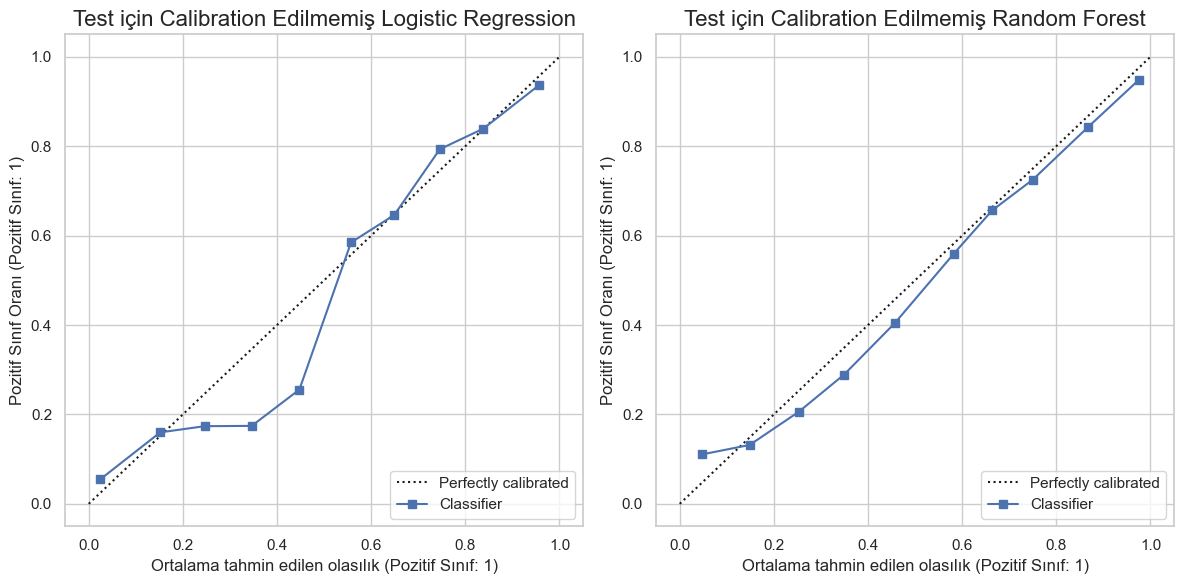

In [7]:
# Test setin kalibrasyon grafiği
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

# CalibrationDisplay.from_predictions tahmin edilen değerlerle tahmin olasılıklarını kullanarak calibration curve grafiğini oluşturmaktadır
# Logistic Regression calibration curve
CalibrationDisplay.from_predictions(y_test, test_probas_logistic, n_bins=10, ax=ax[0])
# Random Forest calibration curve
CalibrationDisplay.from_predictions(y_test, test_probas_RF, n_bins=10, ax=ax[1])

# Görselleştirme ayarları
ax[1].set_xlabel("Ortalama tahmin edilen olasılık (Pozitif Sınıf: 1)")
ax[1].set_ylabel("Pozitif Sınıf Oranı (Pozitif Sınıf: 1)")
ax[1].set_title("Test için Calibration Edilmemiş Random Forest", size=16)
ax[0].set_xlabel("Ortalama tahmin edilen olasılık (Pozitif Sınıf: 1)")
ax[0].set_ylabel("Pozitif Sınıf Oranı (Pozitif Sınıf: 1)")
ax[0].set_title("Test için Calibration Edilmemiş Logistic Regression", size=16)
plt.tight_layout()
plt.show()

### 4. Calibration Aşaması

- Calibration işlemleri gerçekleştirirken eğitim seti üzerinden calibration yapmak aşırı öğrenmeye (overfitting) sebep olabilir, bu yüzden test üzerinden calibration işlemlerini gerçekleştirip sonuçları incelemek daha sağlıklı olacaktır.

#### 4.1. Platt Scaling Calibration Yöntemi

- Platt Scaling model olasılıklarını kalibre edebilmek için model çıktılarını LogisticRegression ile kalibre eden bir yöntemdir.
- CalibratedClassifierCV fonksiyonunda `base_estimator` olarak modelimizi, `method` olarak 'sigmoid' methodunu (Platt Scaling yöntemine denk gelmektedir), önceden modelimizi oluşturduğumuz için `cv` değerini 'prefit' olarak veriyoruz.

In [8]:
# Random Forest için calibration modelinin eğitilmesi
calib_platt_RF = CalibratedClassifierCV(model_RF, method='sigmoid', cv='prefit')
calib_platt_RF.fit(X_test, y_test)

# calibration modeli test kümesi için tahmin olasılıklarının oluşturulması
test_probas_RF_calib_platt = calib_platt_RF.predict_proba(X_test)[:,1]

# roc_auc_score hesaplaması
test_roc_auc_RF_calib_platt = roc_auc_score(y_test, test_probas_RF_calib_platt)

# Model performansının basılması
print("Random Forest Model Performance")
print(f"Test ROC-AUC: {test_roc_auc_RF:.3f}")
print(f"Platt Calibrated Test ROC-AUC: {test_roc_auc_RF_calib_platt:.3f}")

Random Forest Model Performance
Test ROC-AUC: 0.860
Platt Calibrated Test ROC-AUC: 0.860


In [9]:
# Logistic Regression için calibration modelinin eğitilmesi
calib_platt_logistic = CalibratedClassifierCV(model_logistic, method='sigmoid', cv='prefit')
calib_platt_logistic.fit(X_test, y_test)

# calibration modeli test kümesi için tahmin olasılıklarının oluşturulması
test_probas_logistic_calib_platt = calib_platt_logistic.predict_proba(X_test)[:,1]

# roc_auc_score hesaplaması
test_roc_auc_logistic_calib_platt = roc_auc_score(y_test, test_probas_logistic_calib_platt)

# Model performansının basılması
print("Logistic Regression Model Performance")
print(f"Test ROC-AUC: {test_roc_auc_logistic:.3f}")
print(f"Platt Calibrated Test ROC-AUC: {test_roc_auc_logistic_calib_platt:.3f}")

Logistic Regression Model Performance
Test ROC-AUC: 0.858
Platt Calibrated Test ROC-AUC: 0.858


#### 4.2. Isotonic Regression Calibration Yöntemi

- Isotonic Scaling model olasılıklarını kalibre edebilmek Isotonic Regression kullanır, Isotonic Regression da kısaca merdiven benzeri bir şekilde model olasılıklarını düzenleyerek monoton olarak artan bir kalibrasyon haritası oluşturur ve değerleri kalibre eder.
- CalibratedClassifierCV fonksiyonunda `base_estimator` olarak modelimizi, `method` olarak 'isotonic' methodunu (Isotonic Scaling yöntemine denk gelmektedir), önceden modelimizi oluşturduğumuz için `cv` değerini 'prefit' olarak veriyoruz.

In [10]:
# Random Forest için calibration modelinin eğitilmesi
calib_isotonic_RF = CalibratedClassifierCV(model_RF, method='isotonic', cv='prefit')
calib_isotonic_RF.fit(X_test, y_test)

# calibration modeli test kümesi için tahmin olasılıklarının oluşturulması
test_probas_RF_calib_isotonic = calib_isotonic_RF.predict_proba(X_test)[:,1]

# roc_auc_score hesaplaması
test_roc_auc_RF_calib_isotonic = roc_auc_score(y_test, test_probas_RF_calib_isotonic)

# Model performansının basılması
print("RF Model Performance")
print(f"Test ROC-AUC: {test_roc_auc_RF:.3f}")
print(f"Isotonic Calibrated Test ROC-AUC: {test_roc_auc_RF_calib_isotonic:.3f}")

RF Model Performance
Test ROC-AUC: 0.860
Isotonic Calibrated Test ROC-AUC: 0.861


In [11]:
# Logistic Regression için calibration modelinin eğitilmesi
calib_isotonic_logistic = CalibratedClassifierCV(model_logistic, method='isotonic', cv='prefit')
calib_isotonic_logistic.fit(X_test, y_test)

# calibration modeli test kümesi için tahmin olasılıklarının oluşturulması
test_probas_logistic_calib_isotonic = calib_isotonic_logistic.predict_proba(X_test)[:,1]

# roc_auc_score hesaplaması
test_roc_auc_logistic_calib_isotonic = roc_auc_score(y_test, test_probas_logistic_calib_isotonic)

# Model performansının basılması
print("Logistic Regression Model Performance")
print(f"Test ROC-AUC: {test_roc_auc_logistic:.3f}")
print(f"Isotonic Calibrated Test ROC-AUC: {test_roc_auc_logistic_calib_isotonic:.3f}")

Logistic Regression Model Performance
Test ROC-AUC: 0.858
Isotonic Calibrated Test ROC-AUC: 0.863


#### 4.3. Calibration Yöntemlerinin Karşılaştırılması

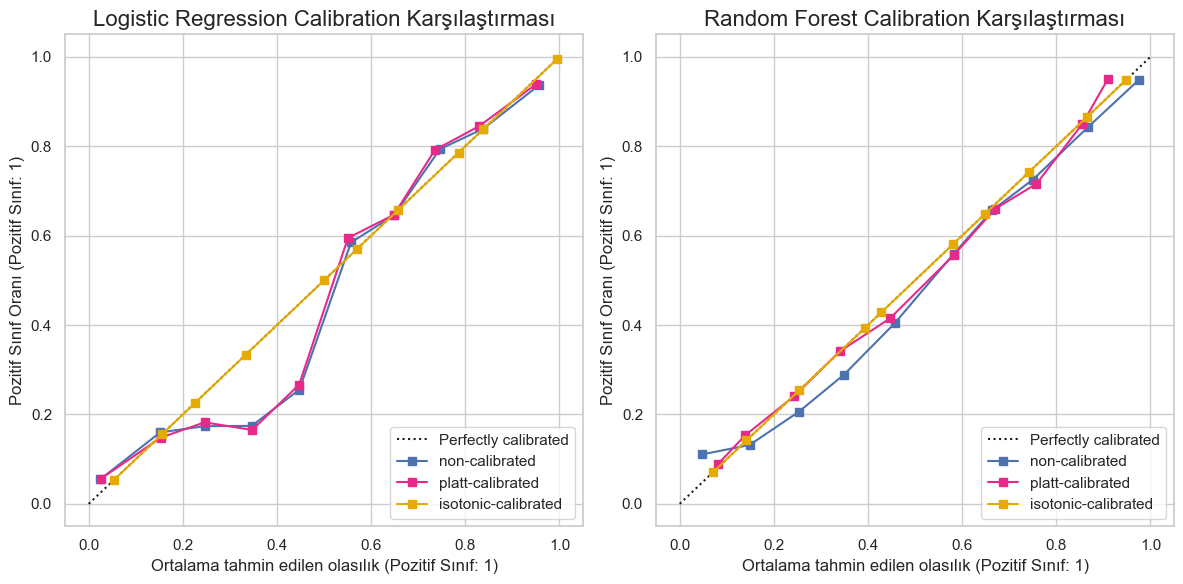

In [12]:
# görselleştirme ayarlarının yapılması
sns.set_theme(style="whitegrid")
colors = plt.get_cmap("Dark2")
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

# görselleştirme için CalibratedClassifierCV ile aynı methodolojiyi uygulayan CalibrationDisplay fonksiyonunu kullanıyoruz
CalibrationDisplay.from_predictions(y_test, test_probas_logistic, n_bins=10, name="non-calibrated", ax=ax[0])
CalibrationDisplay.from_estimator(calib_platt_logistic, X_test, y_test, n_bins=10, name="platt-calibrated", color=colors(3), ax=ax[0])
CalibrationDisplay.from_estimator(calib_isotonic_logistic, X_test, y_test, n_bins=10, name="isotonic-calibrated", color=colors(5), ax=ax[0])

# görselleştirme için CalibratedClassifierCV ile aynı methodolojiyi uygulayan CalibrationDisplay fonksiyonunu kullanıyoruz
CalibrationDisplay.from_predictions(y_test, test_probas_RF, n_bins=10, name="non-calibrated", ax=ax[1])
CalibrationDisplay.from_estimator(calib_platt_RF, X_test, y_test, n_bins=10, name="platt-calibrated", color=colors(3), ax=ax[1])
CalibrationDisplay.from_estimator(calib_isotonic_RF, X_test, y_test, n_bins=10, name="isotonic-calibrated", color=colors(5), ax=ax[1])

# title ve label düzenlemeleri
ax[0].set_xlabel("Ortalama tahmin edilen olasılık (Pozitif Sınıf: 1)")
ax[0].set_ylabel("Pozitif Sınıf Oranı (Pozitif Sınıf: 1)")
ax[0].set_title("Logistic Regression Calibration Karşılaştırması", size=16)

ax[1].set_xlabel("Ortalama tahmin edilen olasılık (Pozitif Sınıf: 1)")
ax[1].set_ylabel("Pozitif Sınıf Oranı (Pozitif Sınıf: 1)")
ax[1].set_title("Random Forest Calibration Karşılaştırması", size=16)

plt.tight_layout()
plt.show()

### 5. Sonuç

- Sonuç olarak sınıflandırma problemlerinde kalibrasyon model olasılıklarının düzenlenmesini ve gerçeği yansıtmasını sağlayarak daha anlamlı kullanılmasını sağlamaktadır fakat model performansına ciddi bir katkıda bulunmaz.